In [2]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *
from constants import *

In [3]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [4]:
%run sequencing_sp2.ipynb

# Open DB

In [243]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'score', 'deficit', 'match_tab_index'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [6]:
hdc = Hdc(10_000, xp)

In [7]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs


((100, 9), (20, 9))


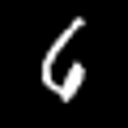
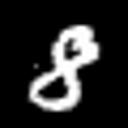
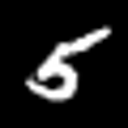
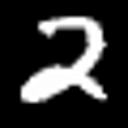
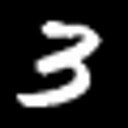
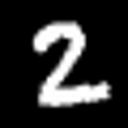
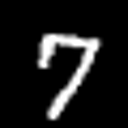
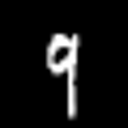
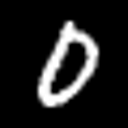
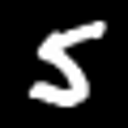
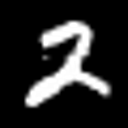
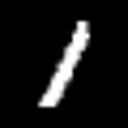
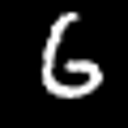
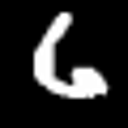
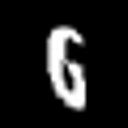
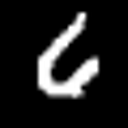

In [8]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Types

In [ ]:
Engram = namedtuple('Engram', ['image_id', 'value', 'si_ind_dict', 'seq', 'phased_seq', 'phased_x_seq', 'phased_y_seq', 'phased_normal_seq', 'max_std_sq'])
Matchee = namedtuple('Matchee', ['si_ind_dict', 'seq', 'xy_seq', 'x_seq', 'y_seq', 'x_sq_seq', 'y_sq_seq', 'normal_seq'])
InterpetResult = namedtuple('InterpetResult', ['score', 'deficit', 'min_score_index', 'scores', 'score_vecs', 'tabs'])

## render_image

In [9]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

## create_engram

In [ ]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

def create_engram(df_image):
    image_id = int(df_image.name)
    value = str(df_image['value'])
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    
    sequence = get_sequence(sequences)
    normal_sequence = get_normal_sequence(sequence, si_ind_dict)
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    
    assert sequence.shape[0] == xy_sequence.shape[0]
    assert xy_sequence.shape[0] == vec_sequence.shape[0]
    assert vec_sequence.shape[0] == normal_sequence.shape[0]

    phased_sequences = []
    phased_xy_sequences = []
    phased_normal_sequences = []
    
    for phase in range(vec_sequence.shape[0]):
        phased_vec_sequence = np.roll(vec_sequence, -phase, axis=0)
        xy_list = [(0, 0)]
            
        for vec in phased_vec_sequence[:-1]:
            xy_list.append((xy_list[-1][0] + vec[0], xy_list[-1][1] + vec[1]))
    
        phased_sequences.append(np.roll(sequence, -phase, axis=0))
        phased_xy_sequences.append(np.array(xy_list))
        phased_normal_sequences.append(np.roll(normal_sequence, -phase, axis=0))
    
    phased_normal_sequences = np.array(phased_normal_sequences)
    phased_xy_sequences = np.array(phased_xy_sequences)
    phased_x_sequences = phased_xy_sequences[..., 0]
    phased_y_sequences = phased_xy_sequences[..., 1]
    # max_std = max(np.std(phased_x_sequences[0]), np.std(phased_y_sequences[0]))
    max_std = SENSOR_RECEPTIVE_FIELD_SIZE * 3
    return Engram(image_id=image_id,
                  value=value,
                  si_ind_dict=si_ind_dict,
                  seq=sequence,
                  phased_seq=phased_sequences, 
                  phased_x_seq=phased_x_sequences, 
                  phased_y_seq=phased_y_sequences, 
                  phased_normal_seq=phased_normal_sequences, 
                  max_std_sq=max_std ** 2)

## create_matchee

In [ ]:
def create_matchee(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    
    sequence = get_sequence(sequences)
    normal_sequence = get_normal_sequence(sequence, si_ind_dict)
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    
    x_seq = xy_sequence[:,0]
    y_seq = xy_sequence[:,1]
    x_sq_seq = x_seq * x_seq
    y_sq_seq = y_seq * y_seq
    
    assert sequence.shape[0] == normal_sequence.shape[0]
    assert normal_sequence.shape[0] == x_seq.shape[0]
    assert x_seq.shape[0] == y_seq.shape[0]
    assert y_seq.shape[0] == x_sq_seq.shape[0]
    assert x_sq_seq.shape[0] == y_sq_seq.shape[0]

    return Matchee(si_ind_dict=si_ind_dict, 
                   seq=sequence, 
                   xy_seq=xy_sequence, 
                   x_seq=x_seq, 
                   y_seq=y_seq, 
                   x_sq_seq=x_sq_seq, 
                   y_sq_seq=y_sq_seq, 
                   normal_seq=normal_sequence)

## _compute_dist_sq_matrix

In [369]:
def _compute_dist_sq_matrix(engram, matchee, matchee_pivot_point_i):
    # Batch compute matrix: (x1 - x2)^2 = x1^2 - 2*x1*x2 + x2^2
    x1 = engram.phased_x_seq.copy()
    x1 = x1.reshape(-1, 1)
    x2 = matchee.x_seq[:,np.newaxis]

    # Move all phased x-es to pivot point
    x1 += x2[matchee_pivot_point_i, 0]
    
    x1_sq = (x1 * x1).T
    x1_sq = np.vstack([x1_sq, np.ones(x1_sq.shape[-1])])
    x2_sq = np.vstack([np.ones(matchee.x_sq_seq.shape[-1]), matchee.x_sq_seq])
    x1_sq_plus_x2_sq = x1_sq.T @ x2_sq
    x1_times_x2 = x1 @ x2.T
    x_dist_sq = x1_sq_plus_x2_sq - (2 * x1_times_x2)
    x_dist_sq = x_dist_sq.reshape(engram.phased_x_seq.shape[0], engram.phased_x_seq.shape[0], matchee.x_seq.shape[0])

    # Batch compute matrix: (y1 - y2)^2 = y1^2 - 2*y1*y2 + y2^2
    y1 = engram.phased_y_seq.copy()
    y1 = y1.reshape(-1, 1)
    y2 = matchee.y_seq[:,np.newaxis]

    # Move all phased y-es to pivot point
    y1 += y2[matchee_pivot_point_i, 0]
    
    y1_sq = (y1 * y1).T
    y1_sq = np.vstack([y1_sq, np.ones(y1_sq.shape[-1])])
    y2_sq = np.vstack([np.ones(matchee.y_sq_seq.shape[-1]), matchee.y_sq_seq])
    y1_sq_plus_y2_sq = y1_sq.T @ y2_sq
    y1_times_y2 = y1 @ y2.T
    y_dist_sq = y1_sq_plus_y2_sq - (2 * y1_times_y2)
    y_dist_sq = y_dist_sq.reshape(engram.phased_y_seq.shape[0], engram.phased_y_seq.shape[0], matchee.y_seq.shape[0])

    # Batch compute matrix: dot_prod(normal1, normal2), then threshold, then square
    n1 = engram.phased_normal_seq.reshape(-1, 2)
    n2 = matchee.normal_seq.T
    n1_dot_prod_n2 = np.abs(n1 @ n2)
    n_dist_sq = np.where(n1_dot_prod_n2 < COS_SIM_45, engram.max_std_sq, 0)
    n_dist_sq = n_dist_sq.reshape(engram.phased_normal_seq.shape[0], engram.phased_normal_seq.shape[0], matchee.normal_seq.shape[0])

    # Resulting distance square matrix combines all of squared dists
    dist_sq = x_dist_sq + y_dist_sq + n_dist_sq
    return dist_sq

def render_interp_result(engram, matchee, pivot_point_i, interp_result):
    min_score = interp_result.scores[interp_result.min_score_index]
    
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    s = engram.phased_seq[interp_result.min_score_index]
    s = np.vstack([s, np.roll(s, -1, axis=0)]).T
    
    xy_list = np.vstack([engram.phased_x_seq[interp_result.min_score_index], engram.phased_y_seq[interp_result.min_score_index]]).T
    xy_list = xy_list.astype('f')
    
    assert s.shape[0] == xy_list.shape[0]
    
    matchee_pt_xy = matchee.xy_seq[pivot_point_i]
    xy_list += matchee_pt_xy
    xy_list = np.hstack([xy_list, np.roll(xy_list, -1, axis=0)])
    
    engram_si_serial_to_xy = {}
    
    for si_serial, (xy_list_row, s_row) in enumerate(zip(xy_list[:-1], s[:-1])):
        pt_from = xy_list_row[0], xy_list_row[1]
        pt_to = xy_list_row[2], xy_list_row[3]
        
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
    
        si_from = engram.si_ind_dict[s_row[0]]
        si_to = engram.si_ind_dict[s_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
        draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    matchee_si_serial_to_xy = {}
    
    for si_serial, (xy_list_row, s_row) in enumerate(zip(zip(matchee.xy_seq, matchee.xy_seq[1:]), zip(matchee.seq, matchee.seq[1:]))):
        pt_from = xy_list_row[0][0], xy_list_row[0][1] 
        pt_to = xy_list_row[1][0], xy_list_row[1][1]
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        # color = 'red' if np.linalg.norm(vec) < 10 else 'gray'
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
    
        si_from = matchee.si_ind_dict[s_row[0]]
        si_to = matchee.si_ind_dict[s_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        # draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    interp_tab = interp_result.tabs[interp_result.min_score_index]
    
    for engram_si_serial, matchee_si_serial, dist in interp_tab:
        if engram_si_serial == -1 or matchee_si_serial == -1:
            continue
            
        engram_si_ind_xy = engram_si_serial_to_xy[engram_si_serial]
        matchee_si_xy = matchee_si_serial_to_xy[matchee_si_serial]
        draw.line([engram_si_ind_xy[0], engram_si_ind_xy[1], matchee_si_xy[0], matchee_si_xy[1]], width=1, fill='white')
    
    draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)

    draw.text((image_pil.size[0] / 2, 10), f'score={min_score:.0f}, {interp_result.score_vecs[interp_result.min_score_index].astype(int)}, def={interp_result.deficit * 100:.0f}%', font_size=24, anchor='mt')
    return image_pil

## interpret

In [ ]:
def interpret(engram, matchee, pivot_point_i):
    dist_sq = _compute_dist_sq_matrix(engram, matchee, pivot_point_i)
    interp_tabs = {} # key - phase_index, value - array (engram_si_serial, matchee_si_serial, dist) = interp tab
    
    for phase_index in range(dist_sq.shape[0]):
        dist_sq_for_phase = dist_sq[phase_index].copy()
        dist_sq_stride = dist_sq_for_phase.shape[1]
        sort_indices = np.argsort(dist_sq_for_phase, axis=None)
    
        interp_tab = []
        i_to_j_dict = {}
        j_to_i_dict = {}
        
        for flat_ij in sort_indices.ravel():
            i = flat_ij // dist_sq_stride
            j = flat_ij % dist_sq_stride
            d = dist_sq_for_phase[i,j]
    
            if d >= 0:
                if d < engram.max_std_sq:
                    interp_tab.append((i, j, d))
                    i_to_j_dict[i] = j
                    j_to_i_dict[j] = i
                    
                dist_sq_for_phase[i,:] = -1
                dist_sq_for_phase[:,j] = -1
    
        interp_tab = np.array(interp_tab, dtype='i8')
        interp_tab_mask = []
    
        phased_sequence = engram.phased_seq[phase_index]
        # Filter out from interp_tab connections which do not belong to adjacent sis on both sides.
        # This way we can filter out unwanted crosses of connections. In other words we favor seq to seq matches
        for interp_tab_row in interp_tab:
            i = interp_tab_row[0]
            j = interp_tab_row[1]
    
            is_standalone = (not (i-1) in i_to_j_dict and not (i+1) in i_to_j_dict and not (j-1) in j_to_i_dict and not (j+1) in j_to_i_dict)
            is_prev_i_ok = i_to_j_dict.get(i-1, -999) in (j-1, j+1)
            is_next_i_ok = i_to_j_dict.get(i+1, -999) in (j-1, j+1)
            is_prev_j_ok = j_to_i_dict.get(j-1, -999) in (i-1, i+1)
            is_next_j_ok = j_to_i_dict.get(j+1, -999) in (i-1, i+1)
    
            interp_tab_mask.append(is_standalone or ((is_prev_i_ok or is_next_i_ok) and (is_prev_j_ok or is_next_j_ok)))
        
        interp_tabs[phase_index] = interp_tab[interp_tab_mask]
    
    interp_score_vecs = np.zeros((len(interp_tabs), 2))
    
    for phase_index, interp_tab in interp_tabs.items():
        unmatched_engram_sis = set(range(dist_sq.shape[0]))
        unmatched_matchee_sis = set(range(dist_sq.shape[2]))

        if interp_tab.size > 0:
            unmatched_engram_sis -= set(interp_tab[:,0])
            unmatched_matchee_sis -= set(interp_tab[:,1])
            
        interp_score_vecs[phase_index] = (len(unmatched_engram_sis), len(unmatched_matchee_sis))
    
    interp_integr_scores = np.sqrt(np.sum(interp_score_vecs ** 2, axis=1))
    min_score_index = np.argmin(interp_integr_scores)
    min_score_vec = interp_score_vecs[min_score_index]
    deficit = (min_score_vec[0] + min_score_vec[1]) / (len(engram.seq) + len(matchee.seq))
    return InterpetResult(score=interp_integr_scores[min_score_index],
                          deficit=deficit,
                          min_score_index=min_score_index,
                          scores=interp_integr_scores,
                          score_vecs=interp_score_vecs,
                          tabs=interp_tabs)

## interpret2

In [390]:
def interpret2(engram, matchee, pivot_point_i):
    dist_sq = _compute_dist_sq_matrix(engram, matchee, pivot_point_i)
    interp_tabs = {} # key - phase_index, value - array (engram_si_serial, matchee_si_serial, dist) = interp tab
    engram_si_serials = frozenset(range(dist_sq.shape[0]))
    matchee_si_serials = frozenset(range(dist_sq.shape[2]))
    
    for phase_index in range(dist_sq.shape[0]):
        dist_sq_for_phase = dist_sq[phase_index].copy()
        dist_sq_stride = dist_sq_for_phase.shape[1]
        sort_indices = np.argsort(dist_sq_for_phase, axis=None)
    
        interp_tab = []
        i_to_j_dict = {}
        j_to_i_dict = {}
        
        for flat_ij in sort_indices.ravel():
            i = flat_ij // dist_sq_stride
            j = flat_ij % dist_sq_stride
            d = dist_sq_for_phase[i,j]
    
            if d < 0:
                continue
                
            if d <= engram.max_std_sq:
                interp_tab.append((i, j, d))
                i_to_j_dict[i] = j
                j_to_i_dict[j] = i
                dist_sq_for_phase[i,:] = -1
                dist_sq_for_phase[:,j] = -1
            else:
                # this and other dists are greater than max_std_sq, no need to continue further
                break

        untouched_engram_sis = engram_si_serials - set(i_to_j_dict.keys())
        untouched_matchee_sis = matchee_si_serials - set(j_to_i_dict.keys())
        interp_tab.extend(map(lambda s: (s, -1, engram.max_std_sq), untouched_engram_sis))
        interp_tab.extend(map(lambda s: (-1, s, engram.max_std_sq), untouched_matchee_sis))
        interp_tab = np.array(interp_tab, dtype='i8')
        interp_tabs[phase_index] = interp_tab
        # interp_tab_mask = []
    
        # phased_sequence = engram.phased_seq[phase_index]
        # # Filter out from interp_tab connections which do not belong to adjacent sis on both sides.
        # # This way we can filter out unwanted crosses of connections. In other words we favor seq to seq matches
        # for interp_tab_row in interp_tab:
        #     i = interp_tab_row[0]
        #     j = interp_tab_row[1]
    
        #     is_standalone = (not (i-1) in i_to_j_dict and not (i+1) in i_to_j_dict and not (j-1) in j_to_i_dict and not (j+1) in j_to_i_dict)
        #     is_prev_i_ok = i_to_j_dict.get(i-1, -999) in (j-1, j+1)
        #     is_next_i_ok = i_to_j_dict.get(i+1, -999) in (j-1, j+1)
        #     is_prev_j_ok = j_to_i_dict.get(j-1, -999) in (i-1, i+1)
        #     is_next_j_ok = j_to_i_dict.get(j+1, -999) in (i-1, i+1)
    
        #     interp_tab_mask.append(is_standalone or ((is_prev_i_ok or is_next_i_ok) and (is_prev_j_ok or is_next_j_ok)))
        
        # interp_tabs[phase_index] = interp_tab[interp_tab_mask]
    
    interp_score_vecs = np.zeros((len(interp_tabs), 3))
    
    for phase_index, interp_tab in interp_tabs.items():
        unmatched_engram_sis = engram_si_serials.copy()
        unmatched_matchee_sis = matchee_si_serials.copy()
    
        if interp_tab.size > 0:
            unmatched_engram_sis -= set(interp_tab[interp_tab[:,1] != -1][:,0])
            unmatched_matchee_sis -= set(interp_tab[interp_tab[:,0] != -1][:,1])
            
        interp_score_vecs[phase_index] = (len(unmatched_engram_sis), len(unmatched_matchee_sis), interp_tab[:,2].sum())
    
    # interp_integr_scores = np.sqrt(np.sum(interp_score_vecs ** 2, axis=1))
    interp_integr_scores = interp_score_vecs[:,2]
    min_score_index = np.argmin(interp_integr_scores)
    min_score_vec = interp_score_vecs[min_score_index]
    deficit = (min_score_vec[0] + min_score_vec[1]) / (len(engram.seq) + len(matchee.seq))
    return InterpetResult(score=interp_integr_scores[min_score_index],
                          deficit=deficit,
                          min_score_index=min_score_index,
                          scores=interp_integr_scores,
                          score_vecs=interp_score_vecs,
                          tabs=interp_tabs)


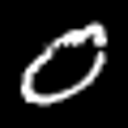
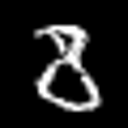
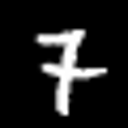
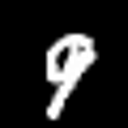
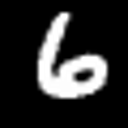
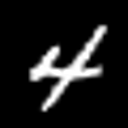
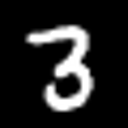
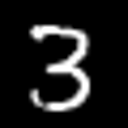

In [370]:
# %%time
image_ids = RNG.choice(df_train_images.index, 8, replace=False)
images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
captions = [f'{image_ids[0]}']

engram_image_id = image_ids[0]
matchee_image_ids = image_ids[1:]
engram = create_engram(df_train_images.loc[engram_image_id])
matchees = list(map(lambda image_id: create_matchee(df_train_images.loc[image_id]), matchee_image_ids))
interp_results = []

for i, (matchee, image_id) in enumerate(zip(matchees, matchee_image_ids)):
    interp_result = interpret2(engram, matchee, 0)
    interp_results.append(interp_result)
    captions.append(f'{i}) {image_id}, score={interp_result.scores[interp_result.min_score_index]:.0f}, def={interp_result.deficit * 100:.0f}%')

display_images_grid(images, captions=captions, col_count=len(image_ids))

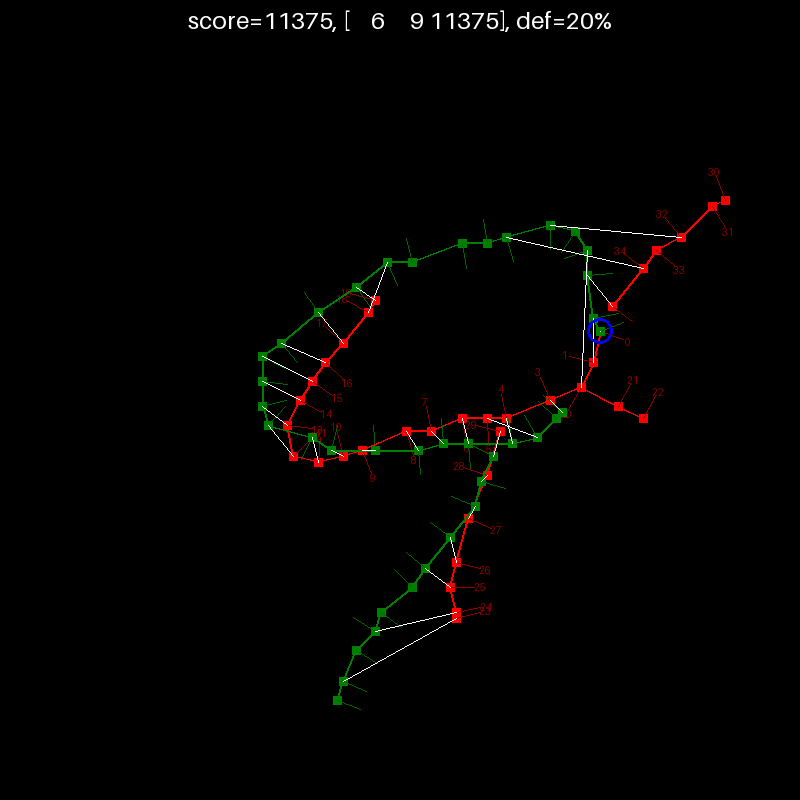

In [341]:
matchee_i = 0
render_interp_result(engram, matchees[matchee_i], 0, interp_results[matchee_i])

# Train

In [371]:
ENGRAMS = []

In [372]:
def get_match_tab(matchee, interpret_func=interpret2):
    match_tab_columns = defaultdict(list)
    
    for engram_i, engram in enumerate(ENGRAMS):
        interp_result = interpret_func(engram, matchee, 0)
        match_tab_columns['engram_i'].append(engram_i)
        match_tab_columns['image_id'].append(engram.image_id)
        match_tab_columns['value'].append(engram.value)
        match_tab_columns['min_score_index'].append(interp_result.min_score_index)
        match_tab_columns['score'].append(interp_result.scores[interp_result.min_score_index])
        match_tab_columns['deficit'].append(interp_result.deficit)
        match_tab_columns['scores'].append(interp_result.scores)
        match_tab_columns['score_vecs'].append(interp_result.score_vecs)

    return pd.DataFrame(match_tab_columns)

In [373]:
# %%time
train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [21514]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]

    for image_id in tqdm(image_ids, leave=False):
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        matchee = create_matchee(df_image)
        df_match_tab = get_match_tab(matchee)
        
        if len(df_match_tab) > 0:
            df_match_tab.sort_values(by=['score'], inplace=True)
            
            # if df_match_tab.iloc[0]['value'] == image_value and df_match_tab.iloc[0]['deficit'] < 0.10:
            if df_match_tab.iloc[0]['value'] == image_value:
                continue

        engram = create_engram(df_image)
        ENGRAMS.append(engram)
        print(f'New engram for {image_id:5} {image_value}')

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

New engram for 45453 2
New engram for 29715 1
New engram for 14795 7
New engram for 57366 2
New engram for  2317 4
New engram for  8327 8
New engram for 39361 4
New engram for 26859 0
New engram for 25418 8
New engram for 18702 6
New engram for 39577 6
New engram for 43990 7
New engram for  9657 7
New engram for 52283 8
New engram for 13548 4
New engram for 17699 3
New engram for 35386 1
New engram for  9945 5
New engram for  9294 3
New engram for 24156 9
New engram for 52188 2
New engram for  3512 8
New engram for 12981 3
New engram for 25260 4
New engram for 29345 0
New engram for  2805 8
New engram for 21321 1
New engram for 55803 9
New engram for 54003 0
New engram for 37376 9
New engram for 35135 9
New engram for 49409 2
New engram for 35136 4
New engram for 20448 2
New engram for  4596 5
New engram for 54315 2
New engram for 33812 6
New engram for 32902 5
New engram for 53171 7
New engram for 33748 5
New engram for  4059 6
New engram for 50992 7
New engram for 29322 9
Total engra

# Test

In [374]:
# %%time
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = [100006748]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee(df_image)
    df_match_tab = get_match_tab(matchee)
    df_match_tab['test_image_id'] = image_id
    match_tabs.append(df_match_tab)
    infer_value = ''
        
    if len(df_match_tab) > 0:
        df_match_tab.sort_values(by=['score'], inplace=True)
        infer_value = df_match_tab.iloc[0]['value']
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(0) # TODO: fix
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(df_match_tab.iloc[0]['image_id'])
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['score'].append(df_match_tab.iloc[0]['score'])
    test_result_rows['deficit'].append(df_match_tab.iloc[0]['deficit'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    
assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

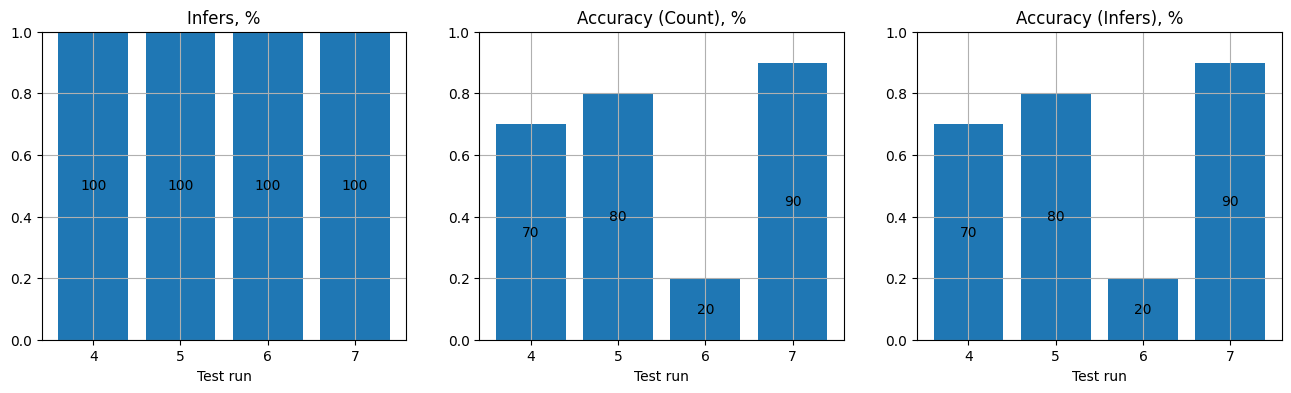

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
4,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,0,20,20,14,1.0,0.7,0.7
5,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,1,20,20,16,1.0,0.8,0.8
6,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,3,20,20,4,1.0,0.2,0.2
7,SQLITE3_SEQ_GRID_0_2_4096,test,[],0,4,20,20,18,1.0,0.9,0.9


In [375]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [376]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'score', 'deficit', 'match_tab_index']]

,test_image_id,true_value,engram_image_id,infer_value,score,deficit,match_tab_index
68,100005854,7,24156,9,9412.0,0.125000,8
77,100002995,6,4596,5,7553.0,0.121212,17


In [377]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_correct = df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value]
df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'score', 'deficit', 'match_tab_index']]
# list(df_correct.match_tab_index)

,test_image_id,true_value,engram_image_id,infer_value,score,deficit,match_tab_index
60,100002350,2,54315,2,11533.0,0.134021,0
61,100004526,3,17699,3,10441.0,0.176471,1
62,100007399,1,29715,1,3892.0,0.105263,2
63,100003425,7,9657,7,7423.0,0.185185,3
64,100008711,5,9945,5,9221.0,0.189189,4
65,100000942,6,18702,6,6400.0,0.121951,5
66,100003216,8,52283,8,9141.0,0.113636,6
67,100004627,6,39577,6,6263.0,0.152542,7
69,100002918,2,45453,2,6838.0,0.068966,9
70,100004125,6,39577,6,6184.0,0.133333,10


In [387]:
match_tab_index = 17
match_tabs[match_tab_index].sort_values(by=['score'], inplace=True)
match_tabs[match_tab_index].head()

,engram_i,image_id,value,min_score_index,score,deficit,scores,score_vecs,test_image_id
34,34,4596,5,3,7553.0,0.121212,"[13853.0, 12379.0, 8399.0, 7553.0, 8636.0, 965...","[[12.0, 8.0, 13853.0], [10.0, 6.0, 12379.0], [...",100002995
10,10,39577,6,21,7830.0,0.157895,"[29867.0, 29638.0, 29460.0, 29459.0, 28896.0, ...","[[23.0, 28.0, 29867.0], [23.0, 28.0, 29638.0],...",100002995
8,8,25418,8,0,8966.0,0.220339,"[8966.0, 10198.0, 12043.0, 14331.0, 17215.0, 1...","[[5.0, 8.0, 8966.0], [6.0, 9.0, 10198.0], [7.0...",100002995
26,26,21321,1,23,9605.0,0.178571,"[15458.0, 17548.0, 18659.0, 19034.0, 19501.0, ...","[[9.0, 15.0, 15458.0], [11.0, 17.0, 17548.0], ...",100002995
39,39,33748,5,9,9796.0,0.142857,"[23869.0, 23519.0, 23427.0, 22658.0, 21273.0, ...","[[21.0, 13.0, 23869.0], [21.0, 13.0, 23519.0],...",100002995


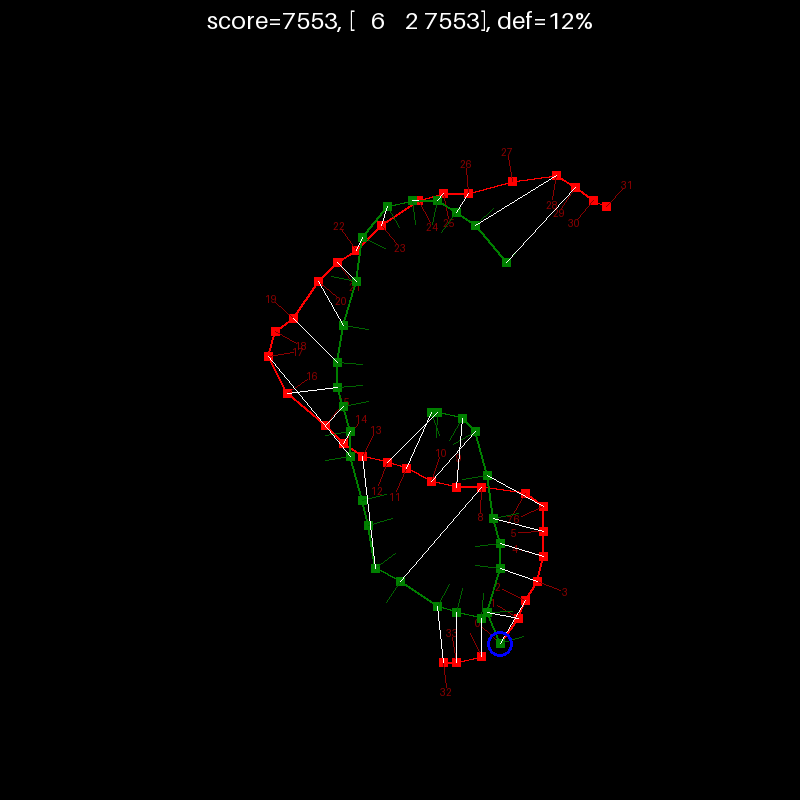

In [388]:
engram_i = match_tabs[match_tab_index].iloc[0]['engram_i']
test_image_id = match_tabs[match_tab_index].iloc[0]['test_image_id']

engram = ENGRAMS[engram_i]
df_image = test_run_source[0].loc[test_image_id]
matchee = create_matchee(df_image)
r = interpret2(engram, matchee, 0)
matchee_i = 1
render_interp_result(engram, matchee, 0, r)

In [182]:
%%time
r = interpret(engram, matchee, 0)

CPU times: user 24.3 ms, sys: 54 μs, total: 24.4 ms
Wall time: 23.5 ms


In [365]:
%%time
dist_sq = _compute_dist_sq_matrix(engram, matchee, pivot_point_i)
interp_tabs = {} # key - phase_index, value - array (engram_si_serial, matchee_si_serial, dist) = interp tab
engram_si_serials = frozenset(range(dist_sq.shape[0]))
matchee_si_serials = frozenset(range(dist_sq.shape[2]))

for phase_index in range(dist_sq.shape[0]):
    dist_sq_for_phase = dist_sq[phase_index].copy()
    dist_sq_stride = dist_sq_for_phase.shape[1]
    sort_indices = np.argsort(dist_sq_for_phase, axis=None)

    interp_tab = []
    i_to_j_dict = {}
    j_to_i_dict = {}
    
    for flat_ij in sort_indices.ravel():
        i = flat_ij // dist_sq_stride
        j = flat_ij % dist_sq_stride
        d = dist_sq_for_phase[i,j]

        if d < 0:
            continue
            
        if d <= engram.max_std_sq:
            interp_tab.append((i, j, d))
            i_to_j_dict[i] = j
            j_to_i_dict[j] = i
            dist_sq_for_phase[i,:] = -1
            dist_sq_for_phase[:,j] = -1
        else:
            # this and other dists are greater than max_std_sq, no need to continue further
            break

    untouched_engram_sis = engram_si_serials - set(i_to_j_dict.keys())
    untouched_matchee_sis = matchee_si_serials - set(j_to_i_dict.keys())
    interp_tab.extend(map(lambda s: (s, -1, engram.max_std_sq), untouched_engram_sis))
    interp_tab.extend(map(lambda s: (-1, s, engram.max_std_sq), untouched_matchee_sis))
    interp_tab = np.array(interp_tab, dtype='i8')
    interp_tabs[phase_index] = interp_tab
    # interp_tab_mask = []

    # phased_sequence = engram.phased_seq[phase_index]
    # # Filter out from interp_tab connections which do not belong to adjacent sis on both sides.
    # # This way we can filter out unwanted crosses of connections. In other words we favor seq to seq matches
    # for interp_tab_row in interp_tab:
    #     i = interp_tab_row[0]
    #     j = interp_tab_row[1]

    #     is_standalone = (not (i-1) in i_to_j_dict and not (i+1) in i_to_j_dict and not (j-1) in j_to_i_dict and not (j+1) in j_to_i_dict)
    #     is_prev_i_ok = i_to_j_dict.get(i-1, -999) in (j-1, j+1)
    #     is_next_i_ok = i_to_j_dict.get(i+1, -999) in (j-1, j+1)
    #     is_prev_j_ok = j_to_i_dict.get(j-1, -999) in (i-1, i+1)
    #     is_next_j_ok = j_to_i_dict.get(j+1, -999) in (i-1, i+1)

    #     interp_tab_mask.append(is_standalone or ((is_prev_i_ok or is_next_i_ok) and (is_prev_j_ok or is_next_j_ok)))
    
    # interp_tabs[phase_index] = interp_tab[interp_tab_mask]

interp_score_vecs = np.zeros((len(interp_tabs), 3))

for phase_index, interp_tab in interp_tabs.items():
    unmatched_engram_sis = engram_si_serials.copy()
    unmatched_matchee_sis = matchee_si_serials.copy()

    if interp_tab.size > 0:
        unmatched_engram_sis -= set(interp_tab[interp_tab[:,1] != -1][:,0])
        unmatched_matchee_sis -= set(interp_tab[interp_tab[:,0] != -1][:,1])
        
    interp_score_vecs[phase_index] = (len(unmatched_engram_sis), len(unmatched_matchee_sis), interp_tab[:,2].sum())

# interp_integr_scores = np.sqrt(np.sum(interp_score_vecs ** 2, axis=1))
interp_integr_scores = interp_score_vecs[:,2]
min_score_index = np.argmin(interp_integr_scores)
min_score_vec = interp_score_vecs[min_score_index]
deficit = (min_score_vec[0] + min_score_vec[1]) / (len(engram.seq) + len(matchee.seq))

CPU times: user 5.75 ms, sys: 1.93 ms, total: 7.67 ms
Wall time: 7.01 ms


In [366]:
min_score_index

np.int64(37)

In [367]:
interp_score_vecs[37]

array([   26.,     0., 15688.])

In [368]:
interp_tabs[37]

array([[  0,   0,   0],
       [  3,   3,   1],
       [ 21,  16,   1],
       [  2,   2,   2],
       [  1,   1,   2],
       [  4,   4,   4],
       [ 19,  15,   8],
       [ 18,  14,  13],
       [ 17,  13,  25],
       [  7,   5,  36],
       [ 13,  10,  37],
       [  8,   6,  40],
       [ 11,   8,  40],
       [ 16,  12,  41],
       [ 10,   7,  45],
       [ 20,  17,  50],
       [ 12,   9,  65],
       [ 15,  11,  73],
       [ 25,  18, 229],
       [  5,  -1, 576],
       [  6,  -1, 576],
       [  9,  -1, 576],
       [ 14,  -1, 576],
       [ 22,  -1, 576],
       [ 23,  -1, 576],
       [ 24,  -1, 576],
       [ 26,  -1, 576],
       [ 27,  -1, 576],
       [ 28,  -1, 576],
       [ 29,  -1, 576],
       [ 30,  -1, 576],
       [ 31,  -1, 576],
       [ 32,  -1, 576],
       [ 33,  -1, 576],
       [ 34,  -1, 576],
       [ 35,  -1, 576],
       [ 36,  -1, 576],
       [ 37,  -1, 576],
       [ 38,  -1, 576],
       [ 39,  -1, 576],
       [ 40,  -1, 576],
       [ 41,  -1